In [1]:
from collections import Counter
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.utils.data
import math
import torch.nn.functional as F

import pandas as pd

In [63]:
knowledgebase_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom.xlsx'
knowledgebase = pd.read_excel(knowledgebase_url)

qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired.dropna(inplace=True)
qa_paired

,Pertanyaan,Jawaban
0,email Fitra A. Bachtiar,fitra.bachtiar[at]ub.ac.id
1,NIK/NIP Fitra A. Bachtiar,198406282019031006
2,nama lengkap Fitra A. Bachtiar,Dr.Eng. Fitra A. Bachtiar
3,Departemen Fitra A. Bachtiar,Departemen Teknik Informatika
4,Program Studi Fitra A. Bachtiar,S2 Ilmu Komputer
...,...,...
1229,Apa Manfaat Konseling FILKOM ?,1. Masalah ditangani oleh ahli yang kompeten d...
1230,Berikan informasi mengenai Layanan Konseling,Informasi mengenai Layanan Konseling dapat dia...
1231,Siapa Konselor Bimbingan dan Konseling di FILK...,Ada 2 konselor Bimbingan dan Konseling di FILK...
1232,Siapa Koordinator Konselor Sebaya ?,Koordinator Konselor Sebaya adalah Muhammad Da...


In [64]:
def remove_punc(string):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in string:
        if char not in punctuations:
            no_punct = no_punct + char  # space is also a character
    return no_punct.lower()

In [75]:
pairs = []
max_len = 45

for line in qa_paired.iterrows():
    pertanyaan = line[1]['Pertanyaan']
    jawaban = line[1]['Jawaban']
    qa_pairs = []
    first = remove_punc(pertanyaan.strip())      
    second = remove_punc(jawaban.strip())
    qa_pairs.append(first.split()[:max_len])
    qa_pairs.append(second.split()[:max_len])
    pairs.append(qa_pairs)

In [76]:
word_freq = Counter()
for pair in pairs:
    word_freq.update(pair[0])
    word_freq.update(pair[1])

In [77]:
min_word_freq = 2
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0

In [78]:
print("Total words are: {}".format(len(word_map)))

Total words are: 952


In [79]:
with open('WORDMAP_corpus_KBFILKOM.json', 'w') as j:
    json.dump(word_map, j)

In [328]:
def encode_question(words, word_map):
    enc_c = [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

def encode_reply(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + \
    [word_map['<end>']] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

def encode_reply_with_maxlen(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<end>']] + [word_map['<pad>']] * (max_len-2 - len(words))
    return enc_c

In [82]:
pairs_encoded = []
for pair in pairs:
    qus = encode_question(pair[0], word_map)
    ans = encode_reply(pair[1], word_map)
    pairs_encoded.append([qus, ans])

with open('pairs_encoded_kbfilkom.json', 'w') as p:
    json.dump(pairs_encoded, p)

In [329]:
pairs_encoded_same_length = []
for pair in pairs:
    qus = encode_question(pair[0], word_map)
    ans = encode_reply_with_maxlen(pair[1], word_map)
    pairs_encoded_same_length.append([qus, ans])

with open('pairs_encoded_kbfilkom_same_len.json', 'w') as p:
    json.dump(pairs_encoded_same_length, p)

In [84]:
rev_word_map = {v: k for k, v in word_map.items()}
' '.join([rev_word_map[v] for v in pairs_encoded[1][0]])

'<unk> fitra a bachtiar <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

In [85]:
class Dataset(Dataset):

    def __init__(self):

        self.pairs = json.load(open('pairs_encoded_kbfilkom.json'))
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):
        
        question = torch.LongTensor(self.pairs[i][0])
        reply = torch.LongTensor(self.pairs[i][1])
            
        return question, reply

    def __len__(self):
        return self.dataset_size

In [319]:
class Dataset_Same_Len(Dataset):

    def __init__(self):

        self.pairs = json.load(open('pairs_encoded_kbfilkom_same_len.json'))
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):
        
        question = torch.LongTensor(self.pairs[i][0])
        reply = torch.LongTensor(self.pairs[i][1])
            
        return question, reply

    def __len__(self):
        return self.dataset_size

In [86]:
train_loader = torch.utils.data.DataLoader(Dataset(),
                                           batch_size = 100, 
                                           shuffle=True, 
                                           pin_memory=True)

In [320]:
train_loader_same_len = torch.utils.data.DataLoader(Dataset_Same_Len(),
                                           batch_size = 50, 
                                           shuffle=True, 
                                           pin_memory=True)

In [87]:
def create_masks(question, reply_input, reply_target):
    
    def subsequent_mask(size):
        mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        return mask.unsqueeze(0)
    
    question_mask = question!=0
    question_mask = question_mask.to(device)
    question_mask = question_mask.unsqueeze(1).unsqueeze(1)         # (batch_size, 1, 1, max_words)
     
    reply_input_mask = reply_input!=0
    reply_input_mask = reply_input_mask.unsqueeze(1)  # (batch_size, 1, max_words)
    reply_input_mask = reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask.data) 
    reply_input_mask = reply_input_mask.unsqueeze(1) # (batch_size, 1, max_words, max_words)
    reply_target_mask = reply_target!=0              # (batch_size, max_words)
    
    return question_mask, reply_input_mask, reply_target_mask

In [88]:
class Embeddings(nn.Module):
    """
    Implements embeddings of the words and adds their positional encodings. 
    """
    def __init__(self, vocab_size, d_model, max_len = 50, num_layers = 6):
        super(Embeddings, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(0.1)
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = self.create_positinal_encoding(max_len, self.d_model)     # (1, max_len, d_model)
        self.te = self.create_positinal_encoding(num_layers, self.d_model)  # (1, num_layers, d_model)
        self.dropout = nn.Dropout(0.1)
        
    def create_positinal_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model).to(device)
        for pos in range(max_len):   # for each position of the word
            for i in range(0, d_model, 2):   # for each dimension of the each position
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)   # include the batch size
        return pe
        
    def forward(self, embedding, layer_idx):
        if layer_idx == 0:
            embedding = self.embed(embedding) * math.sqrt(self.d_model)
        embedding += self.pe[:, :embedding.size(1)]   # pe will automatically be expanded with the same batch size as encoded_words
        # embedding: (batch_size, max_len, d_model), te: (batch_size, 1, d_model)
        embedding += self.te[:, layer_idx, :].unsqueeze(1).repeat(1, embedding.size(1), 1)
        embedding = self.dropout(embedding)
        return embedding

In [89]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, heads, d_model):
        
        super(MultiHeadAttention, self).__init__()
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = nn.Dropout(0.1)
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, 512)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, 512)
        query = self.query(query)
        key = self.key(key)        
        value = self.value(value)   
        
        # (batch_size, max_len, 512) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        
        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0,1,3,2)) / math.sqrt(query.size(-1))
        scores = scores.masked_fill(mask == 0, -1e9)    # (batch_size, h, max_len, max_len)
        weights = F.softmax(scores, dim = -1)           # (batch_size, h, max_len, max_len)
        weights = self.dropout(weights)
        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)
        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, h * d_k)
        context = context.permute(0,2,1,3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)
        # (batch_size, max_len, h * d_k)
        interacted = self.concat(context)
        return interacted 

In [90]:
class FeedForward(nn.Module):

    def __init__(self, d_model, middle_dim = 2048):
        super(FeedForward, self).__init__()
        
        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

In [91]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

In [92]:
class DecoderLayer(nn.Module):
    
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.src_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, embeddings, encoded, src_mask, target_mask):
        query = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, target_mask))
        query = self.layernorm(query + embeddings)
        interacted = self.dropout(self.src_multihead(query, encoded, encoded, src_mask))
        interacted = self.layernorm(interacted + query)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        decoded = self.layernorm(feed_forward_out + interacted)
        return decoded

In [93]:
class Transformer(nn.Module):
    
    def __init__(self, d_model, heads, num_layers, word_map):
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        self.vocab_size = len(word_map)
        self.embed = Embeddings(self.vocab_size, d_model, num_layers = num_layers)
        self.encoder = EncoderLayer(d_model, heads) 
        self.decoder = DecoderLayer(d_model, heads)
        self.logit = nn.Linear(d_model, self.vocab_size)
        
    def encode(self, src_embeddings, src_mask):
        for i in range(self.num_layers):
            src_embeddings = self.embed(src_embeddings, i)
            src_embeddings = self.encoder(src_embeddings, src_mask)
        return src_embeddings
    
    def decode(self, tgt_embeddings, target_mask, src_embeddings, src_mask):
        for i in range(self.num_layers):
            tgt_embeddings = self.embed(tgt_embeddings, i)
            tgt_embeddings = self.decoder(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings
        
    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.encode(src_words, src_mask)
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out

In [94]:
class AdamWarmup:
    
    def __init__(self, model_size, warmup_steps, optimizer):
        
        self.model_size = model_size
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0
        self.lr = 0
        
    def get_lr(self):
        return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_steps ** (-1.5))
        
    def step(self):
        # Increment the number of steps each time we call the step function
        self.current_step += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        # update the learning rate
        self.lr = lr
        self.optimizer.step()       
        

In [95]:
class LossWithLS(nn.Module):

    def __init__(self, size, smooth):
        super(LossWithLS, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False, reduce=False)
        self.confidence = 1.0 - smooth
        self.smooth = smooth
        self.size = size
        
    def forward(self, prediction, target, mask):
        """
        prediction of shape: (batch_size, max_words, vocab_size)
        target and mask of shape: (batch_size, max_words)
        """
        prediction = prediction.view(-1, prediction.size(-1))   # (batch_size * max_words, vocab_size)
        target = target.contiguous().view(-1)   # (batch_size * max_words)
        mask = mask.float()
        mask = mask.view(-1)       # (batch_size * max_words)
        labels = prediction.data.clone()
        labels.fill_(self.smooth / (self.size - 1))
        labels.scatter_(1, target.data.unsqueeze(1), self.confidence)
        loss = self.criterion(prediction, labels)    # (batch_size * max_words, vocab_size)
        loss = (loss.sum(1) * mask).sum() / mask.sum()
        return loss
        

In [111]:
def train(train_loader, transformer, criterion, epoch):
    transformer.train()
    sum_loss = 0
    count = 0

    for i, (question, reply) in enumerate(train_loader):
        
        samples = question.shape[0]

        # Move to device
        question = question.to(device)
        reply = reply.to(device)

        # Prepare Target Data
        reply_input = reply[:, :-1]
        reply_target = reply[:, 1:]

        # Create mask and add dimensions
        question_mask, reply_input_mask, reply_target_mask = create_masks(question, reply_input, reply_target)

        # Get the transformer outputs
        out = transformer(question, question_mask, reply_input, reply_input_mask)

        # Compute the loss
        loss = criterion(out, reply_target, reply_target_mask)
        
        # Backprop
        transformer_optimizer.optimizer.zero_grad()
        loss.backward()
        transformer_optimizer.step()
        
        sum_loss += loss.item() * samples
        count += samples
        
        if i % 100 == 0:
            print("Epoch [{}][{}/{}]\tLoss: {:.3f}".format(epoch, i, len(train_loader), sum_loss/count))
    
    return sum_loss/count

In [112]:
def evaluate(transformer, question, question_mask, max_len, word_map):
    """
    Performs Greedy Decoding with a batch size of 1
    """
    rev_word_map = {v: k for k, v in word_map.items()}
    transformer.eval()
    start_token = word_map['<start>']
    encoded = transformer.encode(question, question_mask)
    words = torch.LongTensor([[start_token]]).to(device)
    
    for step in range(max_len - 1):
        size = words.shape[1]
        target_mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        target_mask = target_mask.to(device).unsqueeze(0).unsqueeze(0)
        decoded = transformer.decode(words, target_mask, encoded, question_mask)
        predictions = transformer.logit(decoded[:, -1])
        _, next_word = torch.max(predictions, dim = 1)
        next_word = next_word.item()
        if next_word == word_map['<end>']:
            break
        words = torch.cat([words, torch.LongTensor([[next_word]]).to(device)], dim = 1)   # (1,step+2)
        
    # Construct Sentence
    if words.dim() == 2:
        words = words.squeeze(0)
        words = words.tolist()
        
    sen_idx = [w for w in words if w not in {word_map['<start>']}]
    sentence = ' '.join([rev_word_map[sen_idx[k]] for k in range(len(sen_idx))])
    
    return sentence

In [ ]:
d_model = 1024
heads = 32
num_layers = 10
epochs = 100


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)
    
transformer = Transformer(d_model = d_model, heads = heads, num_layers = num_layers, word_map = word_map)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.2)

In [139]:
d_model = [512, 1024, 2048, 4096]
heads = [8, 16, 32]
num_layers = [5, 10]
epochs = 100


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)

transformer_experiment = pd.DataFrame(columns = ['experiment_id', 'd_model', 'heads', 'num_layers', 'train_loss'])
loss_history = {}

experiment_id = -1

for d_m in d_model:
    for h in heads:
        for n_l in num_layers:
            experiment_id += 1
            print('\nRunning for experiment {} with d_model {}, heads{}, num_layers{}\n'.format(experiment_id, d_m, h, n_l))

            transformer_experiment.loc[experiment_id, 'experiment_id'] = 'experiment_{}'.format(str(experiment_id))
            transformer_experiment.loc[experiment_id, 'd_model'] = d_m
            transformer_experiment.loc[experiment_id, 'heads'] = h
            transformer_experiment.loc[experiment_id, 'num_layers'] = n_l

            transformer = Transformer(d_model = d_m, heads = h, num_layers = n_l, word_map = word_map)
            transformer = transformer.to(device)
            adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
            transformer_optimizer = AdamWarmup(model_size = d_m, warmup_steps = 4000, optimizer = adam_optimizer)
            criterion = LossWithLS(len(word_map), 0.2)

            loss_list_experiment = []
            for epoch in range(epochs):
                loss_train = train(train_loader, transformer, criterion, epoch)

                state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
                torch.save(state, 'checkpoint_experiment_' + str(epoch) + 'id_'+ str(experiment_id) +'.pth.tar')

                loss_list_experiment.append(loss_train)

            transformer_experiment.loc[experiment_id, 'train_loss'] = loss_train
            loss_history['experiment_{}'.format(str(experiment_id))] = loss_list_experiment



Running for experiment 0 with d_model 512, heads8, num_layers5



/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.126
Epoch [1][0/12]	Loss: 5.096
Epoch [2][0/12]	Loss: 4.918
Epoch [3][0/12]	Loss: 4.604
Epoch [4][0/12]	Loss: 4.495
Epoch [5][0/12]	Loss: 4.376
Epoch [6][0/12]	Loss: 4.111
Epoch [7][0/12]	Loss: 4.152
Epoch [8][0/12]	Loss: 4.048
Epoch [9][0/12]	Loss: 4.058
Epoch [10][0/12]	Loss: 3.987
Epoch [11][0/12]	Loss: 3.937
Epoch [12][0/12]	Loss: 3.984
Epoch [13][0/12]	Loss: 3.906
Epoch [14][0/12]	Loss: 3.775
Epoch [15][0/12]	Loss: 3.783
Epoch [16][0/12]	Loss: 3.665
Epoch [17][0/12]	Loss: 3.631
Epoch [18][0/12]	Loss: 3.630
Epoch [19][0/12]	Loss: 3.413
Epoch [20][0/12]	Loss: 3.389
Epoch [21][0/12]	Loss: 3.342
Epoch [22][0/12]	Loss: 3.224
Epoch [23][0/12]	Loss: 3.125
Epoch [24][0/12]	Loss: 3.241
Epoch [25][0/12]	Loss: 3.146
Epoch [26][0/12]	Loss: 2.981
Epoch [27][0/12]	Loss: 3.044
Epoch [28][0/12]	Loss: 2.902
Epoch [29][0/12]	Loss: 2.708
Epoch [30][0/12]	Loss: 2.804
Epoch [31][0/12]	Loss: 2.685
Epoch [32][0/12]	Loss: 2.724
Epoch [33][0/12]	Loss: 2.412
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.116
Epoch [1][0/12]	Loss: 5.039
Epoch [2][0/12]	Loss: 4.875
Epoch [3][0/12]	Loss: 4.657
Epoch [4][0/12]	Loss: 4.400
Epoch [5][0/12]	Loss: 4.133
Epoch [6][0/12]	Loss: 4.245
Epoch [7][0/12]	Loss: 4.174
Epoch [8][0/12]	Loss: 4.130
Epoch [9][0/12]	Loss: 3.900
Epoch [10][0/12]	Loss: 4.036
Epoch [11][0/12]	Loss: 3.908
Epoch [12][0/12]	Loss: 3.867
Epoch [13][0/12]	Loss: 3.909
Epoch [14][0/12]	Loss: 3.875
Epoch [15][0/12]	Loss: 3.962
Epoch [16][0/12]	Loss: 3.965
Epoch [17][0/12]	Loss: 3.786
Epoch [18][0/12]	Loss: 3.883
Epoch [19][0/12]	Loss: 3.712
Epoch [20][0/12]	Loss: 3.631
Epoch [21][0/12]	Loss: 3.610
Epoch [22][0/12]	Loss: 3.746
Epoch [23][0/12]	Loss: 3.669
Epoch [24][0/12]	Loss: 3.545
Epoch [25][0/12]	Loss: 3.554
Epoch [26][0/12]	Loss: 3.278
Epoch [27][0/12]	Loss: 3.469
Epoch [28][0/12]	Loss: 3.436
Epoch [29][0/12]	Loss: 3.548
Epoch [30][0/12]	Loss: 3.341
Epoch [31][0/12]	Loss: 3.347
Epoch [32][0/12]	Loss: 3.328
Epoch [33][0/12]	Loss: 3.342
Epoch [34][0/12]	Loss: 3

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.240
Epoch [1][0/12]	Loss: 5.157
Epoch [2][0/12]	Loss: 4.977
Epoch [3][0/12]	Loss: 4.736
Epoch [4][0/12]	Loss: 4.441
Epoch [5][0/12]	Loss: 4.322
Epoch [6][0/12]	Loss: 4.310
Epoch [7][0/12]	Loss: 4.092
Epoch [8][0/12]	Loss: 3.945
Epoch [9][0/12]	Loss: 3.846
Epoch [10][0/12]	Loss: 3.933
Epoch [11][0/12]	Loss: 3.846
Epoch [12][0/12]	Loss: 3.892
Epoch [13][0/12]	Loss: 3.762
Epoch [14][0/12]	Loss: 3.846
Epoch [15][0/12]	Loss: 3.716
Epoch [16][0/12]	Loss: 3.591
Epoch [17][0/12]	Loss: 3.711
Epoch [18][0/12]	Loss: 3.638
Epoch [19][0/12]	Loss: 3.351
Epoch [20][0/12]	Loss: 3.510
Epoch [21][0/12]	Loss: 3.465
Epoch [22][0/12]	Loss: 3.241
Epoch [23][0/12]	Loss: 3.305
Epoch [24][0/12]	Loss: 3.181
Epoch [25][0/12]	Loss: 2.849
Epoch [26][0/12]	Loss: 3.305
Epoch [27][0/12]	Loss: 3.038
Epoch [28][0/12]	Loss: 3.026
Epoch [29][0/12]	Loss: 2.808
Epoch [30][0/12]	Loss: 2.641
Epoch [31][0/12]	Loss: 2.757
Epoch [32][0/12]	Loss: 2.687
Epoch [33][0/12]	Loss: 2.594
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.231
Epoch [1][0/12]	Loss: 5.169
Epoch [2][0/12]	Loss: 4.991
Epoch [3][0/12]	Loss: 4.661
Epoch [4][0/12]	Loss: 4.514
Epoch [5][0/12]	Loss: 4.202
Epoch [6][0/12]	Loss: 4.311
Epoch [7][0/12]	Loss: 4.073
Epoch [8][0/12]	Loss: 4.099
Epoch [9][0/12]	Loss: 4.022
Epoch [10][0/12]	Loss: 3.976
Epoch [11][0/12]	Loss: 3.879
Epoch [12][0/12]	Loss: 3.906
Epoch [13][0/12]	Loss: 3.772
Epoch [14][0/12]	Loss: 3.917
Epoch [15][0/12]	Loss: 3.902
Epoch [16][0/12]	Loss: 3.829
Epoch [17][0/12]	Loss: 3.773
Epoch [18][0/12]	Loss: 3.852
Epoch [19][0/12]	Loss: 3.870
Epoch [20][0/12]	Loss: 3.657
Epoch [21][0/12]	Loss: 3.654
Epoch [22][0/12]	Loss: 3.514
Epoch [23][0/12]	Loss: 3.749
Epoch [24][0/12]	Loss: 3.582
Epoch [25][0/12]	Loss: 3.551
Epoch [26][0/12]	Loss: 3.592
Epoch [27][0/12]	Loss: 3.327
Epoch [28][0/12]	Loss: 3.337
Epoch [29][0/12]	Loss: 3.459
Epoch [30][0/12]	Loss: 3.396
Epoch [31][0/12]	Loss: 3.543
Epoch [32][0/12]	Loss: 3.209
Epoch [33][0/12]	Loss: 3.498
Epoch [34][0/12]	Loss: 3

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.161
Epoch [1][0/12]	Loss: 5.073
Epoch [2][0/12]	Loss: 4.881
Epoch [3][0/12]	Loss: 4.554
Epoch [4][0/12]	Loss: 4.291
Epoch [5][0/12]	Loss: 4.344
Epoch [6][0/12]	Loss: 4.065
Epoch [7][0/12]	Loss: 4.007
Epoch [8][0/12]	Loss: 4.118
Epoch [9][0/12]	Loss: 4.064
Epoch [10][0/12]	Loss: 3.916
Epoch [11][0/12]	Loss: 4.049
Epoch [12][0/12]	Loss: 3.933
Epoch [13][0/12]	Loss: 3.839
Epoch [14][0/12]	Loss: 3.645
Epoch [15][0/12]	Loss: 3.871
Epoch [16][0/12]	Loss: 3.761
Epoch [17][0/12]	Loss: 3.708
Epoch [18][0/12]	Loss: 3.582
Epoch [19][0/12]	Loss: 3.384
Epoch [20][0/12]	Loss: 3.420
Epoch [21][0/12]	Loss: 3.390
Epoch [22][0/12]	Loss: 3.399
Epoch [23][0/12]	Loss: 3.197
Epoch [24][0/12]	Loss: 3.179
Epoch [25][0/12]	Loss: 3.114
Epoch [26][0/12]	Loss: 2.941
Epoch [27][0/12]	Loss: 2.917
Epoch [28][0/12]	Loss: 2.825
Epoch [29][0/12]	Loss: 2.853
Epoch [30][0/12]	Loss: 2.822
Epoch [31][0/12]	Loss: 2.783
Epoch [32][0/12]	Loss: 2.639
Epoch [33][0/12]	Loss: 2.505
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.154
Epoch [1][0/12]	Loss: 5.105
Epoch [2][0/12]	Loss: 4.948
Epoch [3][0/12]	Loss: 4.602
Epoch [4][0/12]	Loss: 4.226
Epoch [5][0/12]	Loss: 4.363
Epoch [6][0/12]	Loss: 4.272
Epoch [7][0/12]	Loss: 4.094
Epoch [8][0/12]	Loss: 3.825
Epoch [9][0/12]	Loss: 4.012
Epoch [10][0/12]	Loss: 3.937
Epoch [11][0/12]	Loss: 3.839
Epoch [12][0/12]	Loss: 3.964
Epoch [13][0/12]	Loss: 3.784
Epoch [14][0/12]	Loss: 3.925
Epoch [15][0/12]	Loss: 3.746
Epoch [16][0/12]	Loss: 3.837
Epoch [17][0/12]	Loss: 3.776
Epoch [18][0/12]	Loss: 3.674
Epoch [19][0/12]	Loss: 3.862
Epoch [20][0/12]	Loss: 3.702
Epoch [21][0/12]	Loss: 3.780
Epoch [22][0/12]	Loss: 3.588
Epoch [23][0/12]	Loss: 3.679
Epoch [24][0/12]	Loss: 3.668
Epoch [25][0/12]	Loss: 3.513
Epoch [26][0/12]	Loss: 3.615
Epoch [27][0/12]	Loss: 3.429
Epoch [28][0/12]	Loss: 3.560
Epoch [29][0/12]	Loss: 3.439
Epoch [30][0/12]	Loss: 3.429
Epoch [31][0/12]	Loss: 3.360
Epoch [32][0/12]	Loss: 3.292
Epoch [33][0/12]	Loss: 3.144
Epoch [34][0/12]	Loss: 3

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.314
Epoch [1][0/12]	Loss: 5.197
Epoch [2][0/12]	Loss: 4.910
Epoch [3][0/12]	Loss: 4.548
Epoch [4][0/12]	Loss: 4.350
Epoch [5][0/12]	Loss: 4.027
Epoch [6][0/12]	Loss: 3.892
Epoch [7][0/12]	Loss: 3.812
Epoch [8][0/12]	Loss: 3.959
Epoch [9][0/12]	Loss: 3.917
Epoch [10][0/12]	Loss: 3.949
Epoch [11][0/12]	Loss: 3.882
Epoch [12][0/12]	Loss: 3.785
Epoch [13][0/12]	Loss: 3.751
Epoch [14][0/12]	Loss: 3.803
Epoch [15][0/12]	Loss: 3.658
Epoch [16][0/12]	Loss: 3.482
Epoch [17][0/12]	Loss: 3.401
Epoch [18][0/12]	Loss: 3.346
Epoch [19][0/12]	Loss: 3.474
Epoch [20][0/12]	Loss: 3.166
Epoch [21][0/12]	Loss: 3.120
Epoch [22][0/12]	Loss: 3.160
Epoch [23][0/12]	Loss: 2.795
Epoch [24][0/12]	Loss: 3.016
Epoch [25][0/12]	Loss: 2.804
Epoch [26][0/12]	Loss: 2.722
Epoch [27][0/12]	Loss: 2.809
Epoch [28][0/12]	Loss: 2.657
Epoch [29][0/12]	Loss: 2.386
Epoch [30][0/12]	Loss: 2.517
Epoch [31][0/12]	Loss: 2.363
Epoch [32][0/12]	Loss: 2.379
Epoch [33][0/12]	Loss: 2.366
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.169
Epoch [1][0/12]	Loss: 5.044
Epoch [2][0/12]	Loss: 4.736
Epoch [3][0/12]	Loss: 4.452
Epoch [4][0/12]	Loss: 4.161
Epoch [5][0/12]	Loss: 4.183
Epoch [6][0/12]	Loss: 4.122
Epoch [7][0/12]	Loss: 3.937
Epoch [8][0/12]	Loss: 3.888
Epoch [9][0/12]	Loss: 4.003
Epoch [10][0/12]	Loss: 3.862
Epoch [11][0/12]	Loss: 4.081
Epoch [12][0/12]	Loss: 3.973
Epoch [13][0/12]	Loss: 3.819
Epoch [14][0/12]	Loss: 3.738
Epoch [15][0/12]	Loss: 3.778
Epoch [16][0/12]	Loss: 3.641
Epoch [17][0/12]	Loss: 3.632
Epoch [18][0/12]	Loss: 3.756
Epoch [19][0/12]	Loss: 3.583
Epoch [20][0/12]	Loss: 3.655
Epoch [21][0/12]	Loss: 3.880
Epoch [22][0/12]	Loss: 3.491
Epoch [23][0/12]	Loss: 3.476
Epoch [24][0/12]	Loss: 3.465
Epoch [25][0/12]	Loss: 3.344
Epoch [26][0/12]	Loss: 3.372
Epoch [27][0/12]	Loss: 3.493
Epoch [28][0/12]	Loss: 3.457
Epoch [29][0/12]	Loss: 3.343
Epoch [30][0/12]	Loss: 3.181
Epoch [31][0/12]	Loss: 3.315
Epoch [32][0/12]	Loss: 3.123
Epoch [33][0/12]	Loss: 3.163
Epoch [34][0/12]	Loss: 3

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.138
Epoch [1][0/12]	Loss: 5.068
Epoch [2][0/12]	Loss: 4.806
Epoch [3][0/12]	Loss: 4.552
Epoch [4][0/12]	Loss: 4.333
Epoch [5][0/12]	Loss: 4.271
Epoch [6][0/12]	Loss: 3.967
Epoch [7][0/12]	Loss: 3.895
Epoch [8][0/12]	Loss: 3.907
Epoch [9][0/12]	Loss: 3.809
Epoch [10][0/12]	Loss: 3.811
Epoch [11][0/12]	Loss: 3.897
Epoch [12][0/12]	Loss: 3.914
Epoch [13][0/12]	Loss: 3.752
Epoch [14][0/12]	Loss: 3.701
Epoch [15][0/12]	Loss: 3.493
Epoch [16][0/12]	Loss: 3.629
Epoch [17][0/12]	Loss: 3.631
Epoch [18][0/12]	Loss: 3.176
Epoch [19][0/12]	Loss: 3.344
Epoch [20][0/12]	Loss: 3.255
Epoch [21][0/12]	Loss: 3.251
Epoch [22][0/12]	Loss: 3.130
Epoch [23][0/12]	Loss: 2.814
Epoch [24][0/12]	Loss: 2.923
Epoch [25][0/12]	Loss: 2.883
Epoch [26][0/12]	Loss: 2.717
Epoch [27][0/12]	Loss: 2.519
Epoch [28][0/12]	Loss: 2.679
Epoch [29][0/12]	Loss: 2.557
Epoch [30][0/12]	Loss: 2.450
Epoch [31][0/12]	Loss: 2.366
Epoch [32][0/12]	Loss: 2.322
Epoch [33][0/12]	Loss: 2.278
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.194
Epoch [1][0/12]	Loss: 5.074
Epoch [2][0/12]	Loss: 4.826
Epoch [3][0/12]	Loss: 4.429
Epoch [4][0/12]	Loss: 4.053
Epoch [5][0/12]	Loss: 4.214
Epoch [6][0/12]	Loss: 4.022
Epoch [7][0/12]	Loss: 4.039
Epoch [8][0/12]	Loss: 3.920
Epoch [9][0/12]	Loss: 3.948
Epoch [10][0/12]	Loss: 3.881
Epoch [11][0/12]	Loss: 3.879
Epoch [12][0/12]	Loss: 3.920
Epoch [13][0/12]	Loss: 3.727
Epoch [14][0/12]	Loss: 3.906
Epoch [15][0/12]	Loss: 3.839
Epoch [16][0/12]	Loss: 3.751
Epoch [17][0/12]	Loss: 3.722
Epoch [18][0/12]	Loss: 3.656
Epoch [19][0/12]	Loss: 3.608
Epoch [20][0/12]	Loss: 3.540
Epoch [21][0/12]	Loss: 3.628
Epoch [22][0/12]	Loss: 3.451
Epoch [23][0/12]	Loss: 3.413
Epoch [24][0/12]	Loss: 3.354
Epoch [25][0/12]	Loss: 3.283
Epoch [26][0/12]	Loss: 3.457
Epoch [27][0/12]	Loss: 3.308
Epoch [28][0/12]	Loss: 3.313
Epoch [29][0/12]	Loss: 3.246
Epoch [30][0/12]	Loss: 3.333
Epoch [31][0/12]	Loss: 3.171
Epoch [32][0/12]	Loss: 3.086
Epoch [33][0/12]	Loss: 3.262
Epoch [34][0/12]	Loss: 3

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.137
Epoch [1][0/12]	Loss: 5.055
Epoch [2][0/12]	Loss: 4.730
Epoch [3][0/12]	Loss: 4.431
Epoch [4][0/12]	Loss: 4.356
Epoch [5][0/12]	Loss: 4.020
Epoch [6][0/12]	Loss: 4.005
Epoch [7][0/12]	Loss: 3.936
Epoch [8][0/12]	Loss: 3.883
Epoch [9][0/12]	Loss: 3.836
Epoch [10][0/12]	Loss: 3.959
Epoch [11][0/12]	Loss: 3.865
Epoch [12][0/12]	Loss: 3.872
Epoch [13][0/12]	Loss: 3.809
Epoch [14][0/12]	Loss: 3.751
Epoch [15][0/12]	Loss: 3.664
Epoch [16][0/12]	Loss: 3.663
Epoch [17][0/12]	Loss: 3.580
Epoch [18][0/12]	Loss: 3.483
Epoch [19][0/12]	Loss: 3.358
Epoch [20][0/12]	Loss: 3.305
Epoch [21][0/12]	Loss: 3.139
Epoch [22][0/12]	Loss: 3.129
Epoch [23][0/12]	Loss: 3.005
Epoch [24][0/12]	Loss: 2.861
Epoch [25][0/12]	Loss: 2.866
Epoch [26][0/12]	Loss: 2.893
Epoch [27][0/12]	Loss: 2.729
Epoch [28][0/12]	Loss: 2.773
Epoch [29][0/12]	Loss: 2.326
Epoch [30][0/12]	Loss: 2.620
Epoch [31][0/12]	Loss: 2.350
Epoch [32][0/12]	Loss: 2.437
Epoch [33][0/12]	Loss: 2.333
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.173
Epoch [1][0/12]	Loss: 5.072
Epoch [2][0/12]	Loss: 4.758
Epoch [3][0/12]	Loss: 4.367
Epoch [4][0/12]	Loss: 4.254
Epoch [5][0/12]	Loss: 4.166
Epoch [6][0/12]	Loss: 4.025
Epoch [7][0/12]	Loss: 3.899
Epoch [8][0/12]	Loss: 3.970
Epoch [9][0/12]	Loss: 3.858
Epoch [10][0/12]	Loss: 3.914
Epoch [11][0/12]	Loss: 3.967
Epoch [12][0/12]	Loss: 3.724
Epoch [13][0/12]	Loss: 4.034
Epoch [14][0/12]	Loss: 3.848
Epoch [15][0/12]	Loss: 3.845
Epoch [16][0/12]	Loss: 3.679
Epoch [17][0/12]	Loss: 3.778
Epoch [18][0/12]	Loss: 3.810
Epoch [19][0/12]	Loss: 3.632
Epoch [20][0/12]	Loss: 3.706
Epoch [21][0/12]	Loss: 3.608
Epoch [22][0/12]	Loss: 3.402
Epoch [23][0/12]	Loss: 3.506
Epoch [24][0/12]	Loss: 3.400
Epoch [25][0/12]	Loss: 3.536
Epoch [26][0/12]	Loss: 3.483
Epoch [27][0/12]	Loss: 3.521
Epoch [28][0/12]	Loss: 3.387
Epoch [29][0/12]	Loss: 3.203
Epoch [30][0/12]	Loss: 3.283
Epoch [31][0/12]	Loss: 3.193
Epoch [32][0/12]	Loss: 3.312
Epoch [33][0/12]	Loss: 3.121
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.041
Epoch [1][0/12]	Loss: 4.903
Epoch [2][0/12]	Loss: 4.501
Epoch [3][0/12]	Loss: 4.304
Epoch [4][0/12]	Loss: 3.970
Epoch [5][0/12]	Loss: 4.080
Epoch [6][0/12]	Loss: 3.937
Epoch [7][0/12]	Loss: 3.785
Epoch [8][0/12]	Loss: 3.799
Epoch [9][0/12]	Loss: 3.894
Epoch [10][0/12]	Loss: 3.735
Epoch [11][0/12]	Loss: 3.875
Epoch [12][0/12]	Loss: 3.805
Epoch [13][0/12]	Loss: 3.549
Epoch [14][0/12]	Loss: 3.438
Epoch [15][0/12]	Loss: 3.334
Epoch [16][0/12]	Loss: 3.284
Epoch [17][0/12]	Loss: 3.145
Epoch [18][0/12]	Loss: 3.013
Epoch [19][0/12]	Loss: 3.072
Epoch [20][0/12]	Loss: 2.930
Epoch [21][0/12]	Loss: 2.886
Epoch [22][0/12]	Loss: 2.857
Epoch [23][0/12]	Loss: 2.686
Epoch [24][0/12]	Loss: 2.482
Epoch [25][0/12]	Loss: 2.612
Epoch [26][0/12]	Loss: 2.445
Epoch [27][0/12]	Loss: 2.271
Epoch [28][0/12]	Loss: 2.232
Epoch [29][0/12]	Loss: 2.147
Epoch [30][0/12]	Loss: 2.002
Epoch [31][0/12]	Loss: 2.112
Epoch [32][0/12]	Loss: 2.181
Epoch [33][0/12]	Loss: 1.859
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.147
Epoch [1][0/12]	Loss: 4.975
Epoch [2][0/12]	Loss: 4.512
Epoch [3][0/12]	Loss: 4.261
Epoch [4][0/12]	Loss: 4.202
Epoch [5][0/12]	Loss: 3.967
Epoch [6][0/12]	Loss: 3.937
Epoch [7][0/12]	Loss: 3.927
Epoch [8][0/12]	Loss: 3.770
Epoch [9][0/12]	Loss: 3.912
Epoch [10][0/12]	Loss: 3.953
Epoch [11][0/12]	Loss: 3.699
Epoch [12][0/12]	Loss: 3.827
Epoch [13][0/12]	Loss: 3.753
Epoch [14][0/12]	Loss: 3.735
Epoch [15][0/12]	Loss: 3.726
Epoch [16][0/12]	Loss: 3.631
Epoch [17][0/12]	Loss: 3.631
Epoch [18][0/12]	Loss: 3.416
Epoch [19][0/12]	Loss: 3.660
Epoch [20][0/12]	Loss: 3.599
Epoch [21][0/12]	Loss: 3.384
Epoch [22][0/12]	Loss: 3.425
Epoch [23][0/12]	Loss: 3.368
Epoch [24][0/12]	Loss: 3.360
Epoch [25][0/12]	Loss: 3.310
Epoch [26][0/12]	Loss: 3.241
Epoch [27][0/12]	Loss: 2.948
Epoch [28][0/12]	Loss: 3.226
Epoch [29][0/12]	Loss: 3.187
Epoch [30][0/12]	Loss: 2.942
Epoch [31][0/12]	Loss: 3.123
Epoch [32][0/12]	Loss: 3.080
Epoch [33][0/12]	Loss: 3.034
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.122
Epoch [1][0/12]	Loss: 4.965
Epoch [2][0/12]	Loss: 4.603
Epoch [3][0/12]	Loss: 4.303
Epoch [4][0/12]	Loss: 4.151
Epoch [5][0/12]	Loss: 4.093
Epoch [6][0/12]	Loss: 3.919
Epoch [7][0/12]	Loss: 3.871
Epoch [8][0/12]	Loss: 3.873
Epoch [9][0/12]	Loss: 3.957
Epoch [10][0/12]	Loss: 3.831
Epoch [11][0/12]	Loss: 3.793
Epoch [12][0/12]	Loss: 3.719
Epoch [13][0/12]	Loss: 3.682
Epoch [14][0/12]	Loss: 3.480
Epoch [15][0/12]	Loss: 3.397
Epoch [16][0/12]	Loss: 3.423
Epoch [17][0/12]	Loss: 3.115
Epoch [18][0/12]	Loss: 3.245
Epoch [19][0/12]	Loss: 3.062
Epoch [20][0/12]	Loss: 2.891
Epoch [21][0/12]	Loss: 2.757
Epoch [22][0/12]	Loss: 2.812
Epoch [23][0/12]	Loss: 2.371
Epoch [24][0/12]	Loss: 2.527
Epoch [25][0/12]	Loss: 2.283
Epoch [26][0/12]	Loss: 2.201
Epoch [27][0/12]	Loss: 2.477
Epoch [28][0/12]	Loss: 2.212
Epoch [29][0/12]	Loss: 2.285
Epoch [30][0/12]	Loss: 2.113
Epoch [31][0/12]	Loss: 2.199
Epoch [32][0/12]	Loss: 2.130
Epoch [33][0/12]	Loss: 1.982
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.152
Epoch [1][0/12]	Loss: 5.035
Epoch [2][0/12]	Loss: 4.577
Epoch [3][0/12]	Loss: 4.270
Epoch [4][0/12]	Loss: 4.046
Epoch [5][0/12]	Loss: 3.842
Epoch [6][0/12]	Loss: 3.970
Epoch [7][0/12]	Loss: 3.975
Epoch [8][0/12]	Loss: 3.818
Epoch [9][0/12]	Loss: 3.832
Epoch [10][0/12]	Loss: 3.909
Epoch [11][0/12]	Loss: 3.843
Epoch [12][0/12]	Loss: 3.726
Epoch [13][0/12]	Loss: 3.784
Epoch [14][0/12]	Loss: 3.765
Epoch [15][0/12]	Loss: 3.702
Epoch [16][0/12]	Loss: 3.787
Epoch [17][0/12]	Loss: 3.756
Epoch [18][0/12]	Loss: 3.383
Epoch [19][0/12]	Loss: 3.589
Epoch [20][0/12]	Loss: 3.577
Epoch [21][0/12]	Loss: 3.500
Epoch [22][0/12]	Loss: 3.509
Epoch [23][0/12]	Loss: 3.266
Epoch [24][0/12]	Loss: 3.431
Epoch [25][0/12]	Loss: 3.262
Epoch [26][0/12]	Loss: 3.308
Epoch [27][0/12]	Loss: 3.222
Epoch [28][0/12]	Loss: 3.170
Epoch [29][0/12]	Loss: 3.122
Epoch [30][0/12]	Loss: 3.195
Epoch [31][0/12]	Loss: 3.168
Epoch [32][0/12]	Loss: 3.032
Epoch [33][0/12]	Loss: 3.192
Epoch [34][0/12]	Loss: 3

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.225
Epoch [1][0/12]	Loss: 5.086
Epoch [2][0/12]	Loss: 4.711
Epoch [3][0/12]	Loss: 4.329
Epoch [4][0/12]	Loss: 4.163
Epoch [5][0/12]	Loss: 4.126
Epoch [6][0/12]	Loss: 4.019
Epoch [7][0/12]	Loss: 3.850
Epoch [8][0/12]	Loss: 3.923
Epoch [9][0/12]	Loss: 3.928
Epoch [10][0/12]	Loss: 3.926
Epoch [11][0/12]	Loss: 3.831
Epoch [12][0/12]	Loss: 3.683
Epoch [13][0/12]	Loss: 3.727
Epoch [14][0/12]	Loss: 3.735
Epoch [15][0/12]	Loss: 3.508
Epoch [16][0/12]	Loss: 3.332
Epoch [17][0/12]	Loss: 3.070
Epoch [18][0/12]	Loss: 3.075
Epoch [19][0/12]	Loss: 3.219
Epoch [20][0/12]	Loss: 2.845
Epoch [21][0/12]	Loss: 2.606
Epoch [22][0/12]	Loss: 2.824
Epoch [23][0/12]	Loss: 2.621
Epoch [24][0/12]	Loss: 2.643
Epoch [25][0/12]	Loss: 2.417
Epoch [26][0/12]	Loss: 2.450
Epoch [27][0/12]	Loss: 2.403
Epoch [28][0/12]	Loss: 2.344
Epoch [29][0/12]	Loss: 1.847
Epoch [30][0/12]	Loss: 2.231
Epoch [31][0/12]	Loss: 2.003
Epoch [32][0/12]	Loss: 2.001
Epoch [33][0/12]	Loss: 2.147


KeyboardInterrupt: 

In [142]:
transformer_experiment

,experiment_id,d_model,heads,num_layers,train_loss
0,experiment_0,512,8,5,0.711593
1,experiment_1,512,8,10,1.803816
2,experiment_2,512,16,5,0.712085
3,experiment_3,512,16,10,1.674436
4,experiment_4,512,32,5,0.70525
5,experiment_5,512,32,10,1.712784
6,experiment_6,1024,8,5,0.431497
7,experiment_7,1024,8,10,1.411256
8,experiment_8,1024,16,5,0.429584
9,experiment_9,1024,16,10,1.36271


In [372]:
import yaml

with open('history_rnn_150524.yaml', 'r') as file:
    history_rnn = yaml.load(file, Loader=yaml.FullLoader)

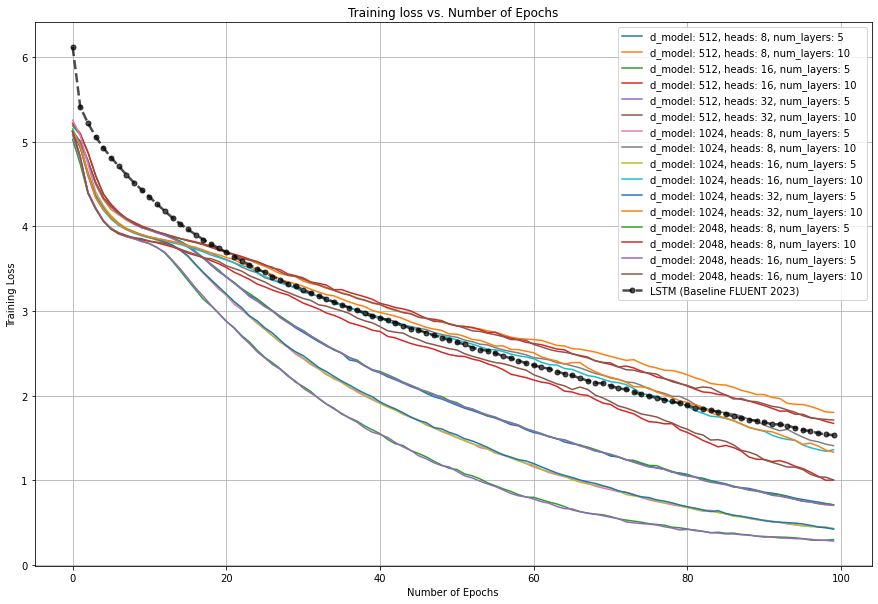

In [389]:
import matplotlib 
import matplotlib.pyplot as plt

loss_history_key = list(loss_history.keys())

plt.figure(figsize=(15,10))
plt.title("Training loss vs. Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
z

for key in loss_history_key:
    loss_list = loss_history[key]
    labels = f'd_model: {transformer_experiment[transformer_experiment["experiment_id"] == key]["d_model"].values[0]}, heads: {transformer_experiment[transformer_experiment["experiment_id"] == key]["heads"].values[0]}, num_layers: {transformer_experiment[transformer_experiment["experiment_id"] == key]["num_layers"].values[0]}'
    plt.plot(loss_list, label = labels)

    
plt.plot(history_rnn['loss'], 
                label = 'LSTM (Baseline FLUENT 2023)', 
                linestyle='dashed', 
                color='black', 
                linewidth=2.5, 
                alpha=0.7, 
                marker='o', 
                markerfacecolor='black', 
                markersize=5
        )

plt.legend()
plt.grid()

In [146]:
d_model = 2048
heads = 16
num_layers = 5
epochs = 100


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)
    
transformer = Transformer(d_model = d_model, heads = heads, num_layers = num_layers, word_map = word_map)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.2)

for epoch in range(epochs):
    loss_train = train(train_loader, transformer, criterion, epoch)

    state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
    torch.save(state, 'checkpoint_' + str(epoch) +'.pth.tar')

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.196
Epoch [1][0/12]	Loss: 5.015
Epoch [2][0/12]	Loss: 4.563
Epoch [3][0/12]	Loss: 4.211
Epoch [4][0/12]	Loss: 4.070
Epoch [5][0/12]	Loss: 3.976
Epoch [6][0/12]	Loss: 3.861
Epoch [7][0/12]	Loss: 3.946
Epoch [8][0/12]	Loss: 3.915
Epoch [9][0/12]	Loss: 3.809
Epoch [10][0/12]	Loss: 3.931
Epoch [11][0/12]	Loss: 3.731
Epoch [12][0/12]	Loss: 3.605
Epoch [13][0/12]	Loss: 3.777
Epoch [14][0/12]	Loss: 3.637
Epoch [15][0/12]	Loss: 3.368
Epoch [16][0/12]	Loss: 3.275
Epoch [17][0/12]	Loss: 3.306
Epoch [18][0/12]	Loss: 3.215
Epoch [19][0/12]	Loss: 2.974
Epoch [21][0/12]	Loss: 2.772
Epoch [22][0/12]	Loss: 2.654
Epoch [23][0/12]	Loss: 2.644
Epoch [24][0/12]	Loss: 2.653
Epoch [25][0/12]	Loss: 2.542
Epoch [26][0/12]	Loss: 2.580
Epoch [27][0/12]	Loss: 2.148
Epoch [28][0/12]	Loss: 2.358
Epoch [29][0/12]	Loss: 2.167
Epoch [30][0/12]	Loss: 2.139
Epoch [31][0/12]	Loss: 2.246
Epoch [32][0/12]	Loss: 2.049
Epoch [33][0/12]	Loss: 1.976
Epoch [34][0/12]	Loss: 2.057
Epoch [35][0/12]	Loss: 1

In [167]:
checkpoint = torch.load('checkpoint_99.pth.tar')
transformer = checkpoint['transformer']

question = "Akademik WA Center" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

<unk>
